In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [228]:
# Create a dtype with the binary data format and the desired column names
dt = np.dtype([('t', 'f4'),('x1', 'f4'), ('x2', 'f4'), ('x3', 'f4'), ('x4', 'f4')])
dataTx = np.fromfile("TX0-data3.log", dtype=dt)
dataRx = np.fromfile("RX1-data3.log", dtype=dt)


dfTx = pd.DataFrame(dataTx)
dfRx = pd.DataFrame(dataRx)

#dfRx = pd.DataFrame(dataRx, columns=["sample", "rx1", "rx2", "rx3", "rx4"])
#dfTx = pd.DataFrame(dataTx, columns=["sample", "tx1", "tx2", "tx3", "tx4"])

dfTx["t"]=dfTx["t"].astype(int) # convert to int
dfRx["t"]=dfRx["t"].astype(int) # convert to int


dfTx.head()

,t,x1,x2,x3,x4
0,0,0.004288,0.809448,0.365326,0.364853
1,1,0.004486,0.808304,0.365524,0.364883
2,2,0.004288,0.809250,0.365356,0.364822
3,3,0.004517,0.808914,0.365570,0.364944
4,4,0.004501,0.809204,0.365784,0.364853


In [3]:
dt = np.dtype([('t', 'f4'), ('msg', 'f4')])
syncDataRx= np.fromfile('RX1-sync3.log', dtype=dt)
syncDataTx= np.fromfile('TX0-sync3.log', dtype=dt)

syncRx = pd.DataFrame(syncDataRx,columns=syncDataRx.dtype.names).astype(int)
syncTx = pd.DataFrame(syncDataTx,columns=syncDataTx.dtype.names).astype(int)

syncRx.head()


,t,msg
0,108526,0
1,114046,1
2,119567,0
3,125087,1
4,130607,0


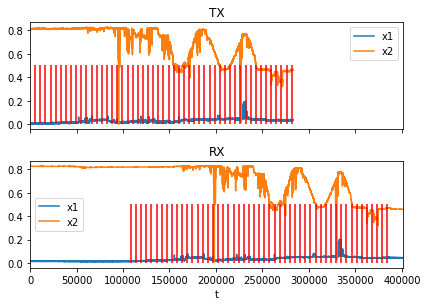

In [4]:
fig, ax = plt.subplots(2, 1)
fig.tight_layout()

dfTx.plot(x="t", y=["x1", "x2"], ax=ax[0] , sharex=ax[1])
ax[0].set_title('TX')
ax[0].set_xlim([0,max([*dfRx["t"],*dfTx["t"]])])
ax[0].vlines(x=syncTx["t"], ymin=0, ymax=0.5, colors='red')

dfRx.plot(x="t", y=["x1", "x2"], ax=ax[1])
ax[1].set_title('RX')
ax[1].set_xlim([0,max([*dfRx["t"],*dfTx["t"]])])
ax[1].vlines(x=syncRx["t"], ymin=0, ymax=0.5, colors='red')

plt.show()


In [5]:
def check_if_lost_messages(df): # not very useful
    messages=df['msg'].tolist();
    sample=df['t'].tolist();

    lost_messages_samples=[];
    for i in range (1,len(messages)):
        if messages[i] == 0:
            continue
        if messages[i] != messages[i-1]+1:
            lost_messages_samples.append[samples[i]]

    return lost_messages_samples

# check if received messages don't follow order from 0 to 7
# ie check if there's skipped messages
print("lost messages? ")
print(check_if_lost_messages(syncRx))

print("equal number of messages sent as received?")
print(len(syncRx['msg'])==len(syncTx['msg']))

lost messages? 
[]
equal number of messages sent as received?
True


In [219]:
#TODO write test for this

# first message received in rx is the same as first message transmitted
# diff = syncRx['t'][0]-syncTx['t'][0] # number of samples to take away from rx

# both tx and rx start at the first message and end at the last message
dfRxCorrected=dfRx.iloc[syncRx['t'][0]:syncRx['t'].iloc[-1]].copy()
dfTxCorrected=dfTx.iloc[syncTx['t'][0]:syncTx['t'].iloc[-1]].copy()


# dClock is the interval in frames at which the TX sends a clock signal 
dClock = 689 * 8 + 8 # equals gCommBlockSpan * context->analogFrames + context->analogFrames

diffTx = []
for i in range(len(syncTx)-1):
    diffTx.append((syncTx['t'][i+1] - syncTx['t'][i])-dClock)  # the indexes in syncTx refer to dfTx (corrected has altered indexes)

# check if messages are received at the same interval
for i in range(len(syncRx)-1): # iterate over received blocks
    
    diff = (syncRx['t'][i+1] - syncRx['t'][i])-dClock

    
    if diff==0: # if spacing between received blocks equals dClock, everything is fine
        continue
    
    if diff>0: # remove extra samples . if larger than one block, check if twice the block +-2 samples
        
        if diff>dClock: # if diff larger than dClock, normalise difference 
            m = np.floor(diff/dClock)
            diff = diff-m*dClock
            if diff == 0: # if difference is equal to n blocks, continue 
                continue
    
        for j in range(diff): # remove n extra samples
            dfRxCorrected = dfRxCorrected.drop(index=(dfRxCorrected.loc[dfRx['t'] == syncRx['t'][i+1]].index-j)[0])

        # check if number of samples is corrected
        #print(dfRxCorrected.loc[dfRx['t'] == syncRx['t'][i+1]].index- dfRxCorrected.loc[dfRx['t'] == syncRx['t'][i]].index) 
    

    if diff<0: 
                
        # interpolation
        
        t2 = syncRx['t'][i+1] + 1# end of current +1
        t1 = syncRx['t'][i+1] # end of current
        x2 = dfRxCorrected.loc[t2,'x1':'x4'].values
        x1 = dfRxCorrected.loc[t1,'x1':'x4'].values 
        
        m = (x2-x1)/(t2-t1)  # point-slope equation -> y = m(x-x0) + y0
        
        print(len(dfRxCorrected))
        dfTop = dfRxCorrected.loc[:t1+1].copy() 
        for i in range(1,abs(diff)+1):
            t = np.round(t1 + i*(t2-t1)/(abs(diff)+1),7)
            x = np.round(m*(t-t1) + x1,7) 
            dfTop.loc[t1+i] = [t,*x]            # now index is not equal to t anymore and t is irrelevant
            
        dfRxCorrected = pd.concat([dfTop,dfRxCorrected.loc[t2:]]) 
        
dfRxCorrected = dfRxCorrected.drop('t', axis=1).reset_index(drop=True)
dfTxCorrected = dfTxCorrected.drop('t', axis=1).reset_index(drop=True)

In [227]:
len(dfRxCorrected)==len(dfTxCorrected)

True

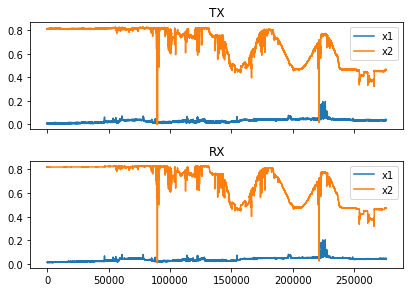

In [224]:
#plot again
fig, ax = plt.subplots(2, 1)
fig.tight_layout()

dfTxCorrected.plot(use_index=True, y=["x1", "x2"], ax=ax[0],sharex=ax[1])
ax[0].set_title('TX')
#ax[0].vlines(x=syncTx["t"], ymin=0, ymax=0.5, colors='red')

dfRxCorrected.plot(use_index=True, y=["x1", "x2"], ax=ax[1])
ax[1].set_title('RX')
#ax[1].vlines(x=syncRx["t"], ymin=0, ymax=0.5, colors='red')


plt.show()
